<a id='1'></a>
# Importing Libraries

In [ ]:
import os
import gc
import ast
import random
from math import sqrt, pi
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from tqdm import tqdm
import torchaudio
import IPython.display as ipd
from collections import Counter
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score
from scipy import signal as sig


import torch
import torch.nn as nn
from torch.optim import Adam
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
import librosa
import librosa.display
from torch.utils.data.dataloader import default_collate




import warnings
warnings.filterwarnings('ignore')

In [2]:
class config:
    seed=2022
    num_fold = 5
    sample_rate= 32_000
    n_fft=1024
    hop_length=512
    n_mels=64
    duration=5
    num_classes = 152
    train_batch_size = 32
    valid_batch_size = 64
    model_name = 'resnet50'
    epochs = 7
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    learning_rate = 1e-2

In [3]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
seed_everything(config.seed)

<a id='2'></a>
# Reading the data

In [4]:
df = pd.read_csv('train_metadata.csv')
df.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,afrsil1,[],"['call', 'flight call']",12.3910,-1.4930,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,2.5,08:00,https://www.xeno-canto.org/125458,afrsil1/XC125458.ogg
1,afrsil1,"['houspa', 'redava', 'zebdov']",['call'],19.8801,-155.7254,Euodice cantans,African Silverbill,Dan Lane,Creative Commons Attribution-NonCommercial-Sha...,3.5,08:30,https://www.xeno-canto.org/175522,afrsil1/XC175522.ogg
2,afrsil1,[],"['call', 'song']",16.2901,-16.0321,Euodice cantans,African Silverbill,Bram Piot,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:30,https://www.xeno-canto.org/177993,afrsil1/XC177993.ogg
3,afrsil1,[],"['alarm call', 'call']",17.0922,54.2958,Euodice cantans,African Silverbill,Oscar Campbell,Creative Commons Attribution-NonCommercial-Sha...,4.0,11:00,https://www.xeno-canto.org/205893,afrsil1/XC205893.ogg
4,afrsil1,[],['flight call'],21.4581,-157.7252,Euodice cantans,African Silverbill,Ross Gallardy,Creative Commons Attribution-NonCommercial-Sha...,3.0,16:30,https://www.xeno-canto.org/207431,afrsil1/XC207431.ogg


In [111]:
scored_birds =pd.DataFrame( {'primary_label' : ["akiapo", "aniani", "apapan", "barpet", "crehon", "elepai", "ercfra", "hawama",
                "hawcre", "hawgoo", "hawhaw", "hawpet1", "houfin", "iiwi", "jabwar", "maupar",
                "omao", "puaioh", "skylar", "warwhe1", "yefcan"]})
df1 = df.merge(scored_birds, on = 'primary_label', how = 'right')

In [7]:
df1 = df.merge(scored_birds, on = 'primary_label', how = 'right')
df1.head()

,primary_label,secondary_labels,type,latitude,longitude,scientific_name,common_name,author,license,rating,time,url,filename
0,akiapo,"['apapan', 'hawama', 'iiwi']",['song'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,12:31,https://www.xeno-canto.org/122399,akiapo/XC122399.ogg
1,akiapo,"['apapan', 'iiwi', 'warwhe1']",['call'],19.6294,-155.3615,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,17:46,https://www.xeno-canto.org/122401,akiapo/XC122401.ogg
2,akiapo,['apapan'],['song'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,4.5,16:22,https://www.xeno-canto.org/122693,akiapo/XC122693.ogg
3,akiapo,"['apapan', 'elepai', 'hawama', 'iiwi', 'omao',...",['call'],19.6642,-155.3896,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,3.5,15:58,https://www.xeno-canto.org/124705,akiapo/XC124705.ogg
4,akiapo,"['apapan', 'hawama', 'iiwi', 'omao', 'warwhe1']",['song'],19.6334,-155.3753,Hemignathus wilsoni,Akiapolaau,Brooks Rownd,Creative Commons Attribution-NonCommercial-Sha...,2.5,14:43,https://www.xeno-canto.org/124801,akiapo/XC124801.ogg


In [8]:
df = df1

<a id='3'></a>
# EDA 

<a id='3.1'></a>
## Analyse Train_Metadata

Rating is a float value between 0.0 and 5.0 as an indicator of the quality rating on Xeno-canto and the number of background species, where 5.0 is the highest and 1.0 is the lowest. 0.0 means that this recording has no user rating yet.

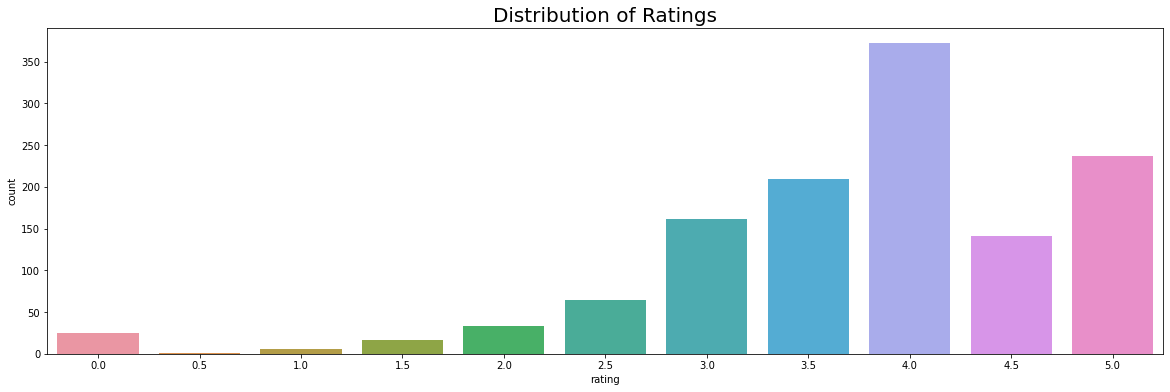

In [10]:
plt.figure(figsize=(20, 6))

sns.countplot(df1['rating'])
plt.title("Distribution of Ratings", fontsize=20)

plt.show()

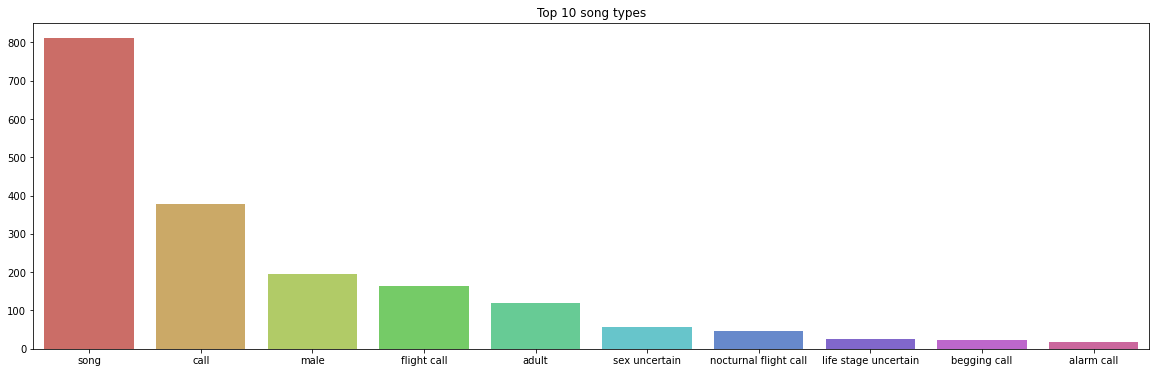

In [11]:
df['type'] = df['type'].apply(lambda x : ast.literal_eval(x))

top = Counter([typ.lower() for lst in df['type'] for typ in lst])

top = dict(top.most_common(10))

plt.figure(figsize=(20, 6))

sns.barplot(x=list(top.keys()), y=list(top.values()), palette='hls')
plt.title("Top 10 song types")

plt.show()

<a id='3.2'></a>
## Analyse Audio Files

In [12]:
filename_1 = df["filename"].values[0] # first training example
ipd.Audio(f"train_audio/{filename_1}")

In [13]:
filename_2 = df["filename"].values[-1] # last training example
ipd.Audio(f"train_audio/{filename_2}")

32000
32000


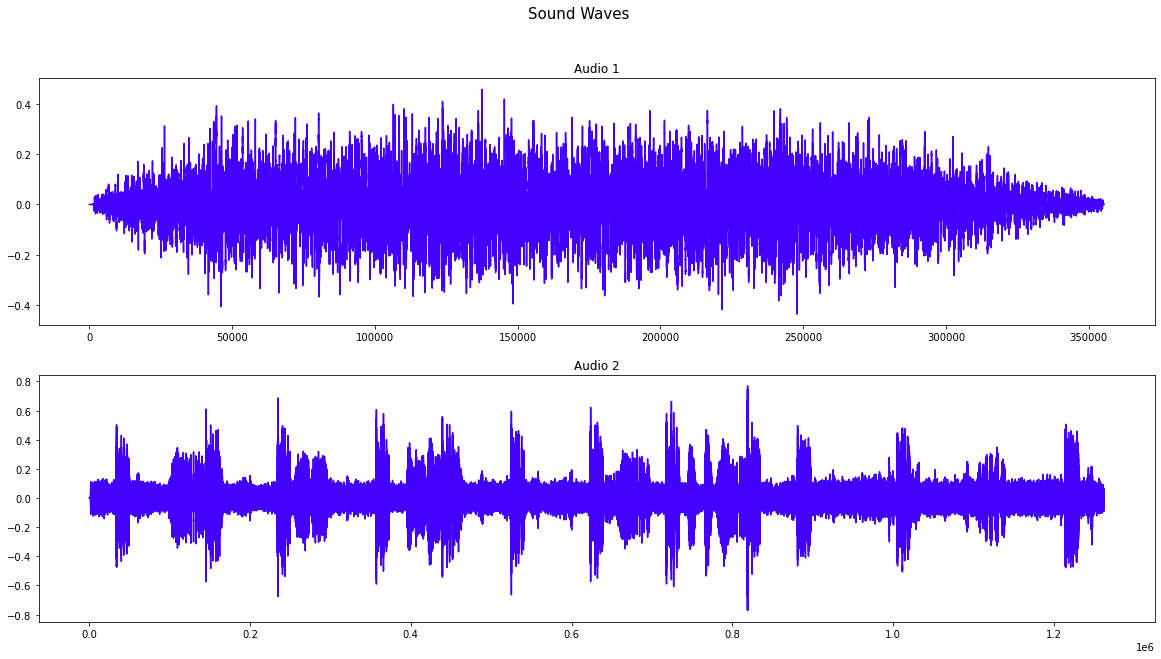

In [10]:
fig, ax = plt.subplots(2, 1, figsize=(20, 10))
fig.suptitle("Sound Waves", fontsize=15)

signal_1, sr = torchaudio.load(f"train_audio/{filename_1}")
# The audio data consist of two things-
# Sound: sequence of vibrations in varying pressure strengths (y)
# Sample Rate: (sr) is the number of samples of audio carried per second, measured in Hz or kHz
print(sr)
sns.lineplot(x=np.arange(len(signal_1[0,:].detach().numpy())), y=signal_1[0,:].detach().numpy(), ax=ax[0], color='#4400FF')
ax[0].set_title("Audio 1")

signal_2, sr = torchaudio.load(f"train_audio/{filename_2}")
sns.lineplot(x=np.arange(len(signal_2[0,:].detach().numpy())), y=signal_2[0,:].detach().numpy(), ax=ax[1], color='#4400FF')
ax[1].set_title("Audio 2")
print(sr)
plt.show()

<a id='4'></a>
# Dataset Preprocessing 

### First of all, as our target variable is in string format, we have to convert it to integer and here I have used LabelEncoder to perform this work.

In [14]:
encoder = LabelEncoder()
df['primary_label_encoded'] = encoder.fit_transform(df['primary_label'])

### Next we created folds.

In [82]:
skf = StratifiedKFold(n_splits=config.num_fold)
for k, (_, val_ind) in enumerate(skf.split(X=df, y=df['primary_label_encoded'])):
    df.loc[val_ind, 'fold'] = k

Нужно понять как использовать атрибуты(Envelope, Q....)


## Sound processing(augmentation)
* Разделение файла на несколько с overlaping
* Noise reduction (пока не нашел простого метода)
* GriffinLim (похоже на деконволюцию, но я до конца не понял) можно попробовать Pytorch audio
* Highcut filter 
* Stretching(pytorh). Мне нравится идея но спектр получается не очень красивый, не понятно как нейросеть его схавает.
* !!! Amplitude to db???


## Feature Extraction
* +Спектрограмма(spectrogram) есть в torchaudio, librosa, scypy  (спектрограммы в лог шкале)
* +MEL spectrogramm дискретная спектрограмма по частотам с треугольным фильтром
* +CWT specrogram aka scalogram. Шкалограмма по CWT
* MFCC spectrogram (дописать описание)
* RGB(Low, Mid, Figh) со спектра
* librosa.feature.rms




### Now let us look at the Mel Spectrogram for the audio loaded during the EDA.

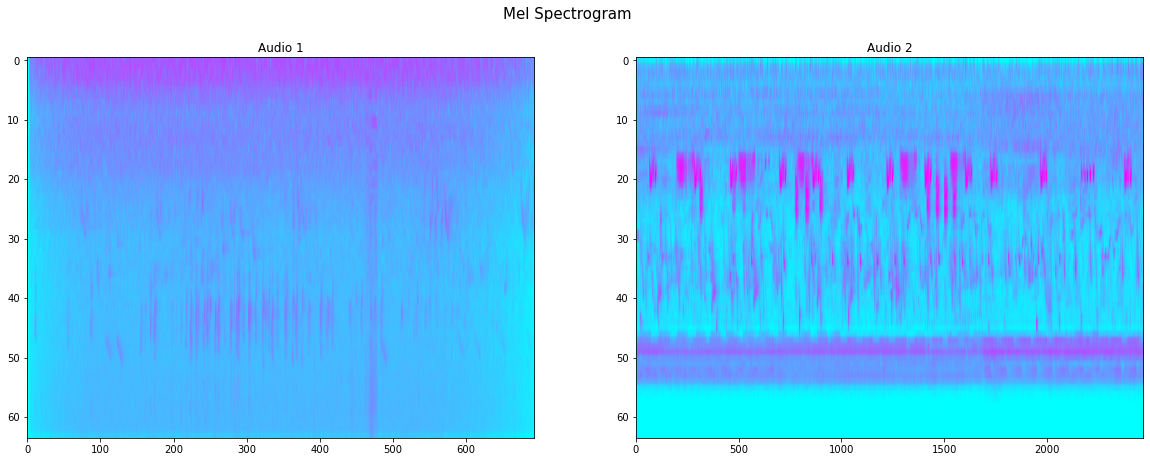

torch.Size([1, 64, 694])


In [36]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Mel Spectrogram", fontsize=15)

mel_spectrogram = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

mel_1 = mel_spectrogram(signal_1)
ax[0].imshow(mel_1.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool', vmin = -12, vmax = 20)
ax[0].set_title("Audio 1")

mel_2 = mel_spectrogram(signal_2)
ax[1].imshow(mel_2.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool',  vmin = -3, vmax = 10)
ax[1].set_title("Audio 2")
plt.show()
print(mel_1.shape)

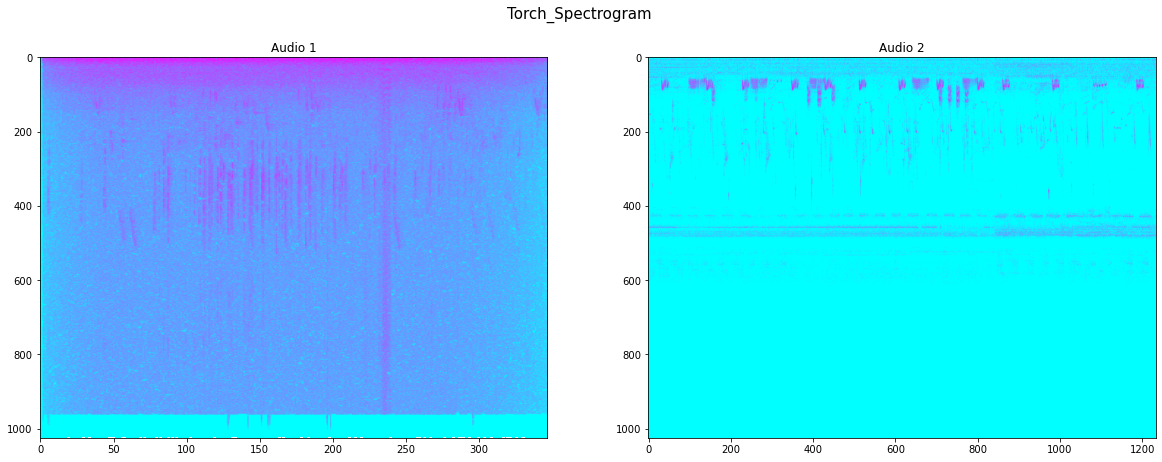

torch.Size([1, 1025, 347])


In [219]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle("Torch_Spectrogram", fontsize=15)

transform = torchaudio.transforms.Spectrogram(n_fft=2048)


spectrogram = transform(signal_1)
ax[0].imshow(spectrogram.log2()[0,:,:].detach().numpy(), aspect='auto', cmap='cool', vmin = -20, vmax = 15)
ax[0].set_title("Audio 1")

spectrogram_2, ph = librosa.magphase(np.array(transform(signal_2)))
spectrogram_2db = librosa.amplitude_to_db(spectrogram_2, ref=np.max)
ax[1].imshow(spectrogram_2db[0,:,:], aspect='auto', cmap='cool')
ax[1].set_title("Audio 2")
plt.show()
print(spectrogram.shape)

### Now let us look at the CWT scalogram

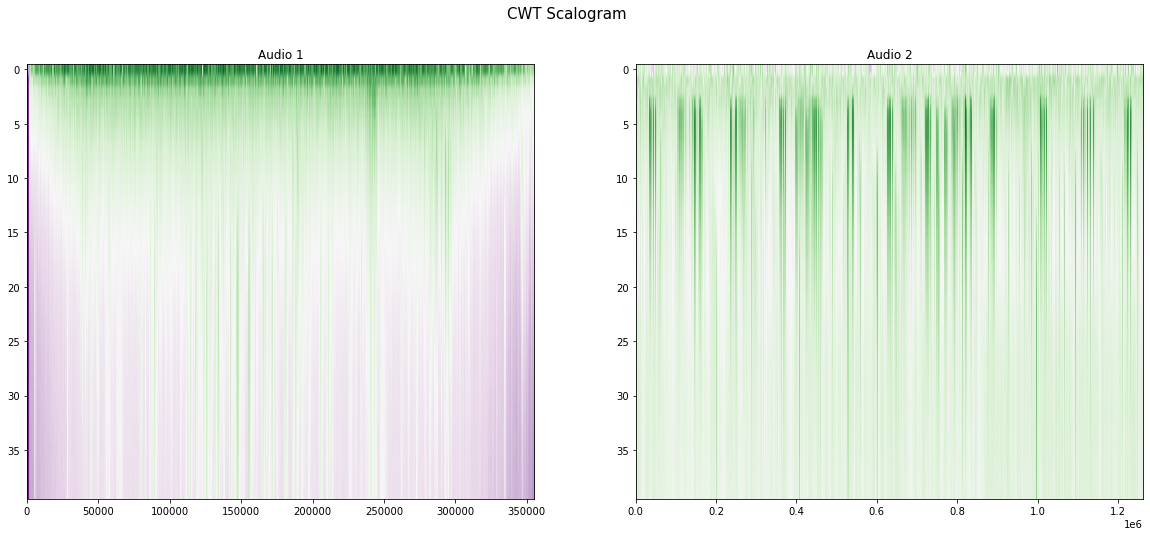

In [52]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('CWT Scalogram', fontsize = 15)

freqs = list(map(int,range(50,8000,200)))

widths = np.array([sr/(sqrt(2.0)*pi*f) for f in freqs])

cwtmatr_1 = sig.cwt(signal_1.reshape(signal_1.shape[0]*signal_1.shape[1]), sig.ricker, widths)
cwtmatr_1 = np.log2(abs(cwtmatr_1))
ax[0].imshow(cwtmatr_1[:,:], cmap='PRGn', aspect='auto',
             vmax=cwtmatr_1.max(), vmin= cwtmatr_1.min()+abs((cwtmatr_1.min()/2)))
ax[0].set_title("Audio 1")

cwtmatr_2 = sig.cwt(signal_2.reshape(signal_2.shape[0]*signal_2.shape[1]), sig.ricker, widths)
cwtmatr_2 = np.log2(abs(cwtmatr_2))
ax[1].imshow(cwtmatr_2[:,:], cmap='PRGn', aspect='auto',
             vmax=cwtmatr_2.max(), vmin= cwtmatr_2.min()+abs((cwtmatr_2.min()/2)))
ax[1].set_title("Audio 2")

plt.show()

In [16]:
S, phase = librosa.magphase(librosa.stft(np.array(signal_2[0,:])))
S_db=librosa.amplitude_to_db(S, ref=np.max)
print(S_db.shape)
rms = librosa.feature.rms(S=S)
fig, ax = plt.subplots(nrows=2, sharex=True,figsize = (6, 6))
times = librosa.times_like(rms)
ax[0].semilogy(times, rms[0], label='RMS Energy')
ax[0].set(xticks=[])
ax[0].legend()
ax[0].label_outer()
librosa.display.specshow(S_db,
                         y_axis='log', x_axis='time', ax=ax[1])
ax[1].set(title='log Power spectrogram')
plt.show()

NameError: name 'signal_2' is not defined

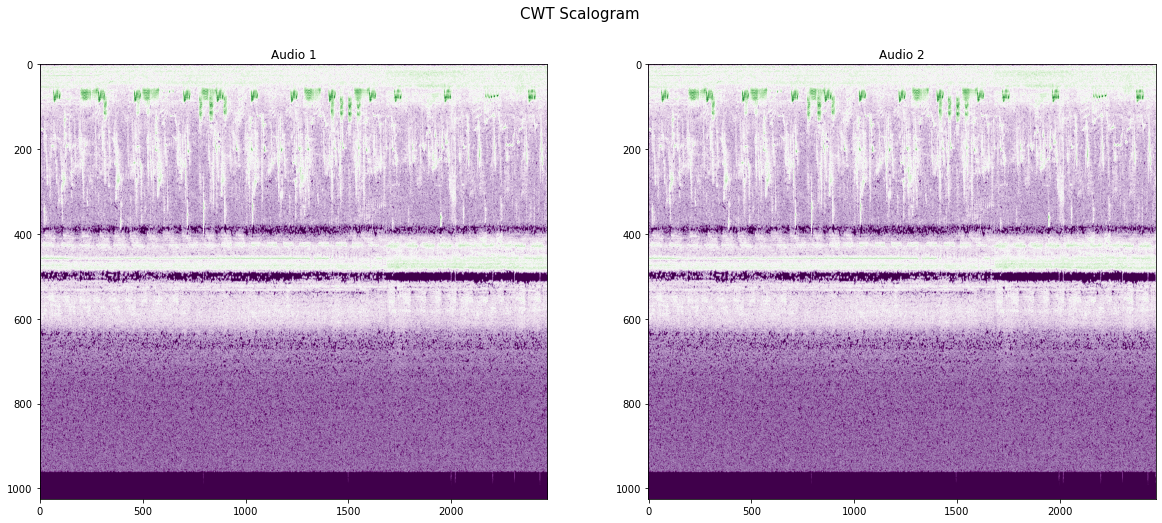

In [213]:
fig, ax = plt.subplots(1, 2, figsize = (20,8))
fig.suptitle('CWT Scalogram', fontsize = 15)


ax[0].imshow(S_db, cmap='PRGn', aspect='auto')
ax[0].set_title("Audio 1")


ax[1].imshow(S_db, cmap='PRGn', aspect='auto')
ax[1].set_title("Audio 2")

plt.show()

### Define list of transforms

In [17]:
#MEL spectrograms
t1 = torchaudio.transforms.MelSpectrogram(sample_rate=config.sample_rate, 
                                                      n_fft=config.n_fft, 
                                                      hop_length=config.hop_length, 
                                                      n_mels=config.n_mels)

#CWT spectrograms
def cwt_spectrogram(audio):
    trace = torch.Tensor.numpy(audio)
    freqs = list(map(int,range(10,4000,200)))
    widths = np.array([sr/(sqrt(2.0)*pi*f) for f in freqs])
    cwt = sig.cwt(trace.reshape(trace.shape[0]*trace.shape[1]), sig.ricker, widths)
    
    return  torch.from_numpy(np.reshape(cwt, (1,len(freqs),trace.shape[1])))

# STFT spectrogram
t2 = torchaudio.transforms.Spectrogram(n_fft=1024)
# Librosa power spectrogram
def librosa_power(audio):
    S, phase = librosa.magphase(librosa.stft(np.array(audio[0,:])))
    S_db=librosa.amplitude_to_db(S, ref=np.max)
    return torch.from_numpy(np.reshape(S_db, (1,S_db.shape[0],S_db.shape[1])))

all_transforms = [t1,t2,librosa_power]

### Pytorch Dataset

In [95]:
class BirdClefDataset(Dataset): 
    def __init__(self, df, transformation, target_sample_rate, duration):
        self.audio_paths = df['filename'].values
        self.labels = df['primary_label_encoded'].values
        self.transformation = transformation
        self.target_sample_rate = target_sample_rate
        self.num_samples = target_sample_rate*duration
        
    def __len__(self):
        return len(self.audio_paths)
    
    def __getitem__(self, index):
        audio_path = f'train_audio/{self.audio_paths[index]}'
        signal_audio, sr = torchaudio.load(audio_path) # loaded the audio
        
        # Now we first checked if the sample rate is same as TARGET_SAMPLE_RATE and if it not equal we perform resampling
        if sr != self.target_sample_rate:
            resampler = torchaudio.transforms.Resample(sr, self.target_sample_rate)
            signal_audio = resampler(signal_audio)
        
        # Next we check the number of channels of the signal_audio
        #signal_audio -> (num_channels, num_samples) - Eg.-(2, 14000) -> (1, 14000)
        if signal_audio.shape[0]>1:
            signal_audio = torch.mean(signal_audio, axis=0, keepdim=True)
        
        # Lastly we check the number of samples of the signal_audio
        #signal_audio -> (num_channels, num_samples) - Eg.-(1, 14000) -> (1, self.num_samples)
        # If it is more than the required number of samples, we truncate the signal_audio
        if signal_audio.shape[1] > self.num_samples:
            signal_audio = signal_audio[:, :self.num_samples]
        
        # If it is less than the required number of samples, we pad the signal_audio
        if signal_audio.shape[1]<self.num_samples:
            num_missing_samples = self.num_samples - signal_audio.shape[1]
            last_dim_padding = (0, num_missing_samples)
            signal_audio = F.pad(signal_audio, last_dim_padding)
            # размерность сигнала = target_sample_rate*duration в начальных параметрах
        # shape signal_audio = 1,224000
        
        # Рассчет различных сейсмограмм
        index = index % len(self.audio_paths)
        if type(self.transformation)==list:
            rs = transforms.Resize((100,438))
            data = []
            labels = []
            for tfm in self.transformation:
                image_one = tfm(signal_audio)
                image = torch.cat([image_one, image_one, image_one])
                max_val = torch.abs(image).max()
                image = image / max_val
                image = rs(image)
                data.append(image)
                
                label = torch.tensor(self.labels[index])
                labels.append(label)
            labels = torch.LongTensor(labels)    
            return torch.stack(data, dim=0), labels
                                
        # For pretrained models, we need 3 channel image, so for that we concatenate the extracted mel
        #image = torch.cat([mel, mel, mel])
        
        # Normalized the image
           
    
        
        return data, label

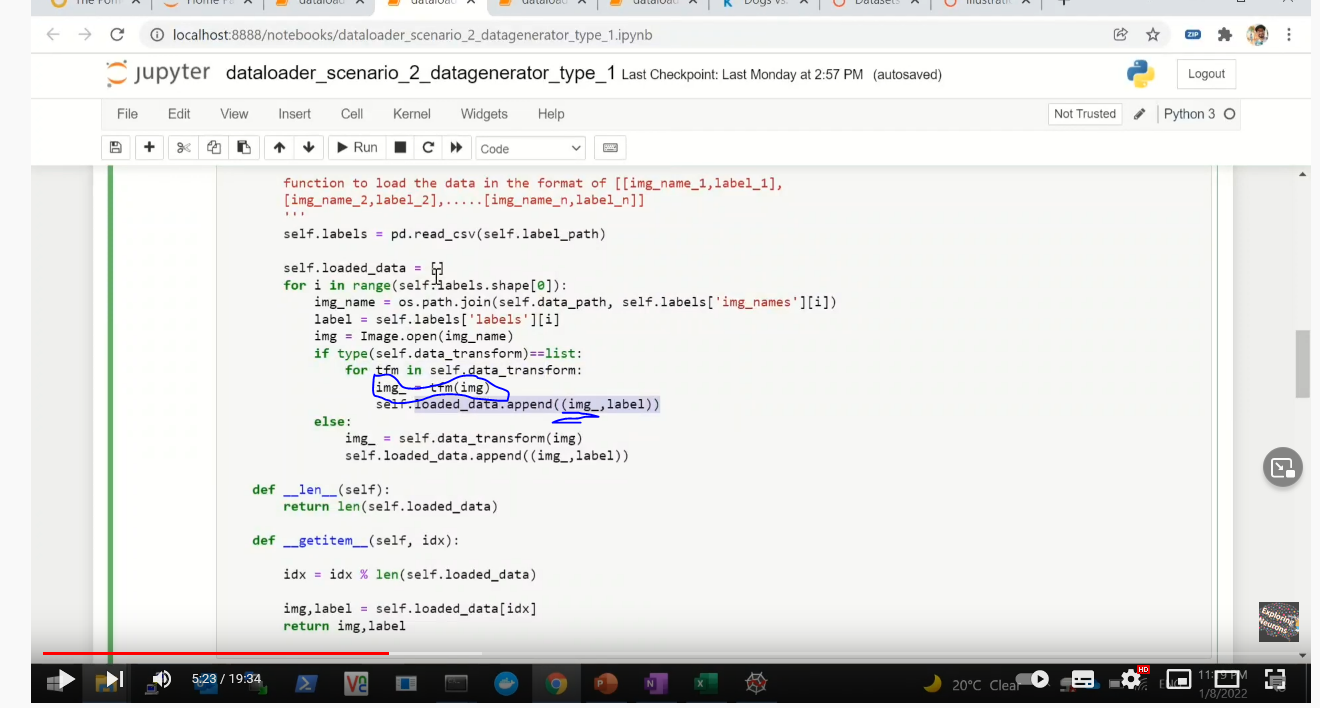

In [19]:
def image_shower(images, labels, n=5):
    plt.figure(figsize=(20, 20))
    for i, image in enumerate(images[:n]):
        plt.subplot(n, n, i+1)        
        plt.imshow(image[0,:,:].detach().numpy(), aspect='auto', cmap='cool')
    print(labels)

In [96]:
def my_collate_func(batch):
    batch = default_collate(batch)
    #assert(len(batch) == 2)
    batch_size, num_aug, channels, height, width = batch[0].size()
    batch[0] = batch[0].view([batch_size * num_aug, channels, height, width])
    batch[1] = batch[1].view([batch_size * num_aug])
    return batch

In [97]:
# Function to get data according to the folds
def get_data(fold):
    train_df = df[df['fold'] != fold].reset_index(drop=True)
    valid_df = df[df['fold'] == fold].reset_index(drop=True)
    
    train_dataset = BirdClefDataset(train_df, all_transforms, config.sample_rate, config.duration)
    valid_dataset = BirdClefDataset(valid_df, all_transforms, config.sample_rate, config.duration)
    
    train_loader = DataLoader(train_dataset, batch_size=config.train_batch_size,collate_fn=my_collate_func, shuffle=True)
    valid_loader = DataLoader(valid_dataset, batch_size=config.valid_batch_size,collate_fn=my_collate_func, shuffle=False)
    
    return train_loader, valid_loader

In [98]:
train_loader, valid_loader = get_data(2)


data,label=next(iter(train_loader))
print(data.shape, label.shape)




torch.Size([96, 3, 100, 438]) torch.Size([96])


<a id='5'></a>
# Model 

### So I will first start with a custom CNN model. After that, we will see the usage of pretrained and other advanced models.

In [64]:
class BirdClefModel(nn.Module):
    def __init__(self):
        super(BirdClefModel, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128*8*54, 64)
        self.fc2 = nn.Linear(64, config.num_classes)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        
        return x

### Now we will fine tune a pretrained model. Here I have used Resnet50. You can use any pretrained model and do experiments.

In [65]:
class BirdCLEFResnet(nn.Module):
    def __init__(self):
        super(BirdCLEFResnet, self).__init__()
        self.base_model = models.__getattribute__(config.model_name)(pretrained=True)
        for param in self.base_model.parameters():
            param.requires_grad = False
            
        in_features = self.base_model.fc.in_features
        
        self.base_model.fc = nn.Sequential(
            nn.Linear(in_features, 1024), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(1024, 512), 
            nn.ReLU(), 
            nn.Dropout(p=0.2),
            nn.Linear(512, config.num_classes))
        
    def forward(self, x):
        x = self.base_model(x)
        return x

<a id='6'></a>
# Utility Function

### Next we define some functions to train the model. These are the basic functions which we use to train any pytorch based models.

In [24]:
def loss_fn(outputs, labels):
    return nn.CrossEntropyLoss()(outputs, labels)

def train(model, data_loader, optimizer, scheduler, device, epoch):
    model.train()
    model = model.float()
    
    running_loss = 0
    loop = tqdm(data_loader, position=0)
    for i, (mels, labels) in enumerate(loop):
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels.float())
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels.long())
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        if scheduler is not None:
            scheduler.step()
            
        running_loss += loss.item()
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())

    return running_loss/len(data_loader)

In [25]:
def valid(model, data_loader, device, epoch):
    model.eval()
    model = model.float()
    
    running_loss = 0
    pred = []
    label = []
    
    loop = tqdm(data_loader, position=0)
    for mels, labels in loop:
        mels = mels.to(device)
        labels = labels.to(device)
        
        outputs = model(mels.float())
        _, preds = torch.max(outputs, 1)
        
        loss = loss_fn(outputs, labels.long())
            
        running_loss += loss.item()
        
        pred.extend(preds.view(-1).cpu().detach().numpy())
        label.extend(labels.view(-1).cpu().detach().numpy())
        
        loop.set_description(f"Epoch [{epoch+1}/{config.epochs}]")
        loop.set_postfix(loss=loss.item())
        
    valid_f1 = f1_score(label, pred, average='macro')
    
    return running_loss/len(data_loader), valid_f1

In [26]:
def run(fold):
    train_loader, valid_loader = get_data(fold)
    
    model = BirdClefModel().to(config.device)
    #model = BirdCLEFResnet().to(config.device)
    
    optimizer = Adam(model.parameters(), lr=config.learning_rate)
    
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, eta_min=1e-5, T_max=10)
    
    best_valid_f1 = 0
    for epoch in range(config.epochs):
        train_loss = train(model, train_loader, optimizer, scheduler, config.device, epoch)
        valid_loss, valid_f1 = valid(model, valid_loader, config.device, epoch)
        if valid_f1 > best_valid_f1:
            print(f"Validation F1 Improved - {best_valid_f1} ---> {valid_f1}")
            torch.save(model.state_dict(), f'./model_{fold}.bin')
            print(f"Saved model checkpoint at ./model_{fold}.bin")
            best_valid_f1 = valid_f1
            
    return best_valid_f1

<a id='7'></a>
# Training 

In [ ]:
for fold in range(config.num_fold):
    print("=" * 30)
    print("Training Fold - ", fold)
    print("=" * 30)
    best_valid_f1 = run(fold)
    print(f'Best F1 Score: {best_valid_f1:.5f}')
    
    gc.collect()
    torch.cuda.empty_cache()    
    #break # To run for all the folds, just remove this break

Training Fold -  0


Epoch [1/2]: 100%|████████████████████████████████████████████████████████████| 4/4 [01:36<00:00, 24.08s/it, loss=1.65]


Validation F1 Improved - 0 ---> 0.029735355337496282
Saved model checkpoint at ./model_0.bin


Epoch [2/2]: 100%|████████████████████████████████████████████████████████████| 4/4 [01:44<00:00, 26.07s/it, loss=1.82]


Best F1 Score: 0.02974
Training Fold -  1


Epoch [1/2]:   9%|█████▌                                                     | 3/32 [00:44<07:19, 15.15s/it, loss=23.9]

In [39]:
import json

In [49]:
test_audio_dir = 'C:/Users/nbuser/_Files/Kaggle/Bird_clef/test_soundscapes/'
file_list = [f.split('.')[0] for f in sorted(os.listdir(test_audio_dir))]

In [37]:
len(file_list)

1

In [27]:
SCORED_BIRDS = ["akiapo", "aniani", "apapan", "barpet", "crehon", "elepai", "ercfra", "hawama",
                "hawcre", "hawgoo", "hawhaw", "hawpet1", "houfin", "iiwi", "jabwar", "maupar",
                "omao", "puaioh", "skylar", "warwhe1", "yefcan"]

In [61]:
model = BirdCLEFResnet()

In [62]:
state_dict = torch.load("model_0.bin")
model.load_state_dict(state_dict)

<All keys matched successfully>

In [40]:
# Load scored birds
with open('scored_birds.json') as sbfile:
    scored_birds = json.load(sbfile)

In [ ]:
# This is where we will store our results
pred = {'row_id': [], 'target': []}

# Process audio files and make predictions
for afile in file_list:
    
    # Complete file path
    path = test_audio_dir + afile + '.ogg'
    
    # Open file with librosa and split signal into 5-second chunks
    sig, rate = torchaudio.load(path)
    #sig.shape = (1323000,)
    
    # Let's assume we have a list of 12 audio chunks (1min / 5s == 12 segments)
    chunks = [[] for i in range(12)]
    
    # Make prediction for each chunk
    # Each scored bird gets a random value in our case
    # since we don't actually have a model
    for i in range(len(chunks)): 
        chunk_start_time = (i) * 5 * rate
        chunk_end_time = (i + 1) * 5 * rate
        test_audio = sig[chunk_start_time:chunk_end_time]
        for bird in scored_birds:
            rs = transforms.Resize((100,438))
            data = []
            
            for tfm in all_transforms:
                image_one = tfm(test_audio)
                image = torch.cat([image_one, image_one, image_one])
                max_val = torch.abs(image).max()
                image = image / max_val
                image = rs(image)
                data.append(image)
                         
            data = torch.stack(data, dim=0)
            print(data.shape)
            model.eval()
            with torch.no_grad():
                outputs = model(data)
                outputs = outputs.clone().detach()
                _, preds = torch.max(outputs, 1)
                             
            # This is our random prediction score for this bird
            score = preds
            print(score)
            # Assemble the row_id which we need to do for each scored bird
            row_id = afile + '_' + bird + '_' + str(int(chunk_end_time/rate))
            
            # Put the result into our prediction dict and
            # apply a "confidence" threshold of 0.5
            pred['row_id'].append(row_id)
            print(pred)
            pred['target'].append(True if score > 0.5 else False)

In [43]:
# Make a new data frame and look at some results        
results = pd.DataFrame(pred, columns = ['row_id', 'target'])

# Quick sanity check
print(results) 
    
# Convert our results to csv
results.to_csv("submission.csv", index=False)    

                              row_id  target
0      soundscape_453028782_akiapo_5   False
1      soundscape_453028782_aniani_5   False
2      soundscape_453028782_apapan_5   False
3      soundscape_453028782_barpet_5   False
4      soundscape_453028782_crehon_5    True
..                               ...     ...
247     soundscape_453028782_omao_60    True
248   soundscape_453028782_puaioh_60    True
249   soundscape_453028782_skylar_60    True
250  soundscape_453028782_warwhe1_60    True
251   soundscape_453028782_yefcan_60   False

[252 rows x 2 columns]
